In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from collections import Counter
import re
import torch.nn as nn
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,BertPreTrainedModel, BertConfig,BertModel, AutoTokenizer,Trainer, TrainingArguments, AdamW, get_scheduler
import torch
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [3]:
print(torch.cuda.is_available())

True


In [4]:
data = pd.read_csv(r'C:\Users\anura\OneDrive\Desktop\proj\updated_data.csv', encoding= "ISO-8859-1")

In [5]:
data.head()

,Corpus,Tweet Text,Stance,Foundation,cleaned_tweet
0,EVM,#EVMs are easy to manipulate . This was demons...,-1,fairness,NaN
1,CAA,Congratulations\nCAA is arrived #CAA,1,loyalty,NaN
2,CAA,My dear Indian muslims we are 35 crores of pop...,-1,loyalty,NaN
3,CAA,This guy was part of anti Hindu protests in th...,0,fairness,NaN
4,CAA,Woman protester breaks down while speaking to ...,0,care,NaN


In [6]:
class_counts = data.iloc[:, 0].value_counts()

print("Number of rows for each class:")
print(class_counts)

total_rows = data.shape[0]
print("\nTotal number of rows:", total_rows)

Number of rows for each class:
Corpus
CAA                     206
UCC                     190
EVM                     178
Animal Sacrifices       166
Anti Conversion Laws    162
LGBTQ                   153
Brain Drain             147
Name: count, dtype: int64

Total number of rows: 1202


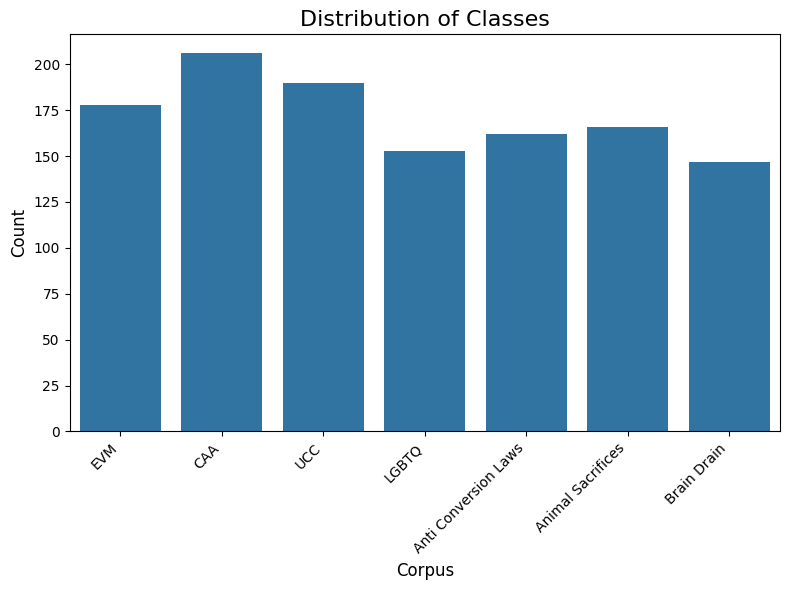

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Corpus', data=data)
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Corpus', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.tight_layout()
plt.show()

In [8]:
def clean_tweet(tweet):
    tweet = re.sub(r'@[\w_]+', '', tweet)  
    tweet = re.sub(r'#\w+', '', tweet)     
    tweet = re.sub(r'http\S+|www\S+', '', tweet)  
    tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet) 
    tweet = tweet.strip().lower()
    return tweet

In [9]:
data['Tweet Text'] = data['Tweet Text'].apply(clean_tweet)

In [10]:
data.head()

,Corpus,Tweet Text,Stance,Foundation,cleaned_tweet
0,EVM,are easy to manipulate this was demonstrated ...,-1,fairness,NaN
1,CAA,congratulations\ncaa is arrived,1,loyalty,NaN
2,CAA,my dear indian muslims we are 35 crores of pop...,-1,loyalty,NaN
3,CAA,this guy was part of anti hindu protests in th...,0,fairness,NaN
4,CAA,woman protester breaks down while speaking to ...,0,care,NaN


### Zero Shot predictions for initial prdictions
####     -Using hugging face bart-large-mnli model for making predictions
####     -Classifying a total of 15% of the total tweets 

In [11]:
#classifier
classifier = pipeline("zero-shot-classification", model = "facebook/bart-large-mnli",device = 0)


Device set to use cuda:0


In [41]:
moral_foundations = ["Care", "Fairness", "Loyalty", "Authority", "Liberty"]

In [12]:
#data seg
zero_samples = data.sample(frac=0.50, random_state=55)



In [13]:
# Select threshold for final multi-label classification
final_threshold = 0.40
all_predicted_labels = []
d = dict()
scores = []
for text in zero_samples["Tweet Text"]:
    result = classifier(text, moral_foundations)
    print(result)
    scores.append(result['scores'])
    # Append selected labels
    selected_labels = [label for label, score in zip(result["labels"], result["scores"]) if score >= final_threshold]
    d[text] = tuple(selected_labels)
    all_predicted_labels.extend(selected_labels)

# Count label occurrences
label_counts = Counter(all_predicted_labels)

{'sequence': 'Equality sounds great, but can the UCC respect cultural nuances too? #UCCDebate', 'labels': ['Fairness', 'Care', 'Liberty', 'Authority', 'Loyalty'], 'scores': [0.5379896759986877, 0.21785101294517517, 0.0940038412809372, 0.08362331241369247, 0.06653212755918503]}
{'sequence': 'Competing priorities political realities and delicate balancing between what’s immediately possible and what could potentially disrupt peace and progress made so far. #CAA took a while, saw widespread protests and #ShaheenBagh. It didn’t concern a single Indian Muslim.', 'labels': ['Care', 'Authority', 'Fairness', 'Loyalty', 'Liberty'], 'scores': [0.4520793855190277, 0.2984597980976105, 0.10296794772148132, 0.0912013128399849, 0.055291563272476196]}
{'sequence': 'The anti conversion law in Maharashtra is a great move by NDA govt', 'labels': ['Authority', 'Care', 'Liberty', 'Loyalty', 'Fairness'], 'scores': [0.5894452929496765, 0.23402360081672668, 0.07622256129980087, 0.06647174060344696, 0.03383684

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


{'sequence': 'This is against God. LGBTQ should not be normalized.', 'labels': ['Care', 'Loyalty', 'Authority', 'Fairness', 'Liberty'], 'scores': [0.2651238739490509, 0.22824646532535553, 0.21602341532707214, 0.15589414536952972, 0.1347121000289917]}
{'sequence': 'In India, religion is deeply personal, and no law should dictate who someone can or cannot believe in. Let’s stand for freedom of thought and belief', 'labels': ['Liberty', 'Care', 'Loyalty', 'Fairness', 'Authority'], 'scores': [0.507288932800293, 0.1698671281337738, 0.12779058516025543, 0.12167148292064667, 0.07338184863328934]}
{'sequence': 'Why does it matter who someone loves? Let them live their life.', 'labels': ['Care', 'Fairness', 'Loyalty', 'Liberty', 'Authority'], 'scores': [0.31627386808395386, 0.2698209881782532, 0.20012474060058594, 0.12815307080745697, 0.08562728762626648]}
{'sequence': 'These laws are nothing but a political tool to oppress. Religion is personal, not a battleground. #StopTheControl', 'labels': 

In [14]:
print(scores)

[[0.5379896759986877, 0.21785101294517517, 0.0940038412809372, 0.08362331241369247, 0.06653212755918503], [0.4520793855190277, 0.2984597980976105, 0.10296794772148132, 0.0912013128399849, 0.055291563272476196], [0.5894452929496765, 0.23402360081672668, 0.07622256129980087, 0.06647174060344696, 0.03383684158325195], [0.48740288615226746, 0.15790428221225739, 0.13878129422664642, 0.10933281481266022, 0.10657870769500732], [0.3756873309612274, 0.2753317654132843, 0.12089879810810089, 0.12012375891208649, 0.10795833170413971], [0.36997854709625244, 0.18692916631698608, 0.18124794960021973, 0.1475100964307785, 0.11433432996273041], [0.46773990988731384, 0.16992653906345367, 0.15753580629825592, 0.1394243836402893, 0.06537330895662308], [0.40457481145858765, 0.2492128610610962, 0.13073161244392395, 0.10781624913215637, 0.10766444355249405], [0.42857837677001953, 0.23637813329696655, 0.18869975209236145, 0.09086601436138153, 0.055477727204561234], [0.2651238739490509, 0.22824646532535553, 0.2

In [15]:
len(all_predicted_labels) 

294

In [16]:
len(zero_samples["Tweet Text"])

613

In [17]:
d = {k: v for k, v in d.items() if len(d[k]) != 0}

In [18]:
print(d)

{'Equality sounds great, but can the UCC respect cultural nuances too? #UCCDebate': ('Fairness',), 'Competing priorities political realities and delicate balancing between what’s immediately possible and what could potentially disrupt peace and progress made so far. #CAA took a while, saw widespread protests and #ShaheenBagh. It didn’t concern a single Indian Muslim.': ('Care',), 'The anti conversion law in Maharashtra is a great move by NDA govt': ('Authority',), 'Stop using animal sacrifice as a tool to target minorities.': ('Care',), 'Religious practices are personal. Why should RSS dictate terms? #FreedomToChoose': ('Liberty',), 'Sacrificing animals does not lead to spiritual growth, it perpetuates harm. We can practice our beliefs in ways that reflect love, not violence.': ('Care',), 'The CAA debate should center on justice for everyone involved.': ('Fairness',), 'In India, religion is deeply personal, and no law should dictate who someone can or cannot believe in. Let’s stand for

In [ ]:
len(d)

# Loading Zero Shot data
- Zero shot classification is done using chatgpt llm
- Classified about 50% of the total tweets

In [11]:
data1 = pd.read_csv("Few_shot.csv")
data1.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Corpus,Tweet Text,Stance,Foundation
0,406,406,406,406,Brain Drain,"Why do they leave? High taxes, corruption, or ...",1,Authority
1,26,26,26,26,EVM,"At this rate, soon #EVM's will be on Amazon an...",-1,Fairness
2,548,548,548,548,Animal Sacrifices,Animal sacrifice laws must protect animals wit...,0,Fairness
3,174,174,174,174,LGBTQ,"how many ""peak bengaluru"" tweets are just gig ...",-1,Authority
4,180,180,180,180,Anti Conversion Laws,Silent conversion is happening in every state ...,1,Fairness


In [11]:
data1 = data[data["Foundation"].notna()]

In [12]:
from collections import Counter

d = dict()  # Dictionary to store tweet text and selected labels
all_predicted_labels = []  # List to collect all predicted labels

# Loop through each Tweet Text
for text in data1["Tweet Text"]:
    # Assuming you have a classifier that returns a list of selected labels for each text
    # result = classifier(text, moral_foundations)  # Uncomment if you have a classifier

    # Simulating selected labels (replace this with actual logic)
    selected_labels = data1.loc[data1["Tweet Text"] == text, "Foundation"].tolist()

    # Store in dictionary
    d[text] = tuple(selected_labels)
    # Collect all labels for counting
    all_predicted_labels.extend(selected_labels)

# Count occurrences of each label
label_counts = Counter(all_predicted_labels)

# Display results
print(d)  # Dictionary with text → labels
print(label_counts)  # Count of each foundation label


{'are easy to manipulate  this was demonstrated by the  in 2009': ('fairness',), 'congratulations\ncaa  is arrived': ('loyalty',), 'my dear indian muslims we are 35 crores of population in india if we get united each  every politician  hindutvawadis will become useless\r\n\r\nremember the  protests': ('loyalty',), 'this guy was part of anti hindu protests in the name of  in which many hindus were kiiied\n\ntoday hes enjoying celebrity life': ('fairness',), 'woman protester breaks down while speaking to ndtvs ravish kumar at delhis': ('care', 'purity'), 'so its clear now protest against  is not for politicaldemocratic reason its ghazwaehindanti hindu and pure fanatic islamic movement': ('purity', 'loyalty'), 'delhi with \n\n \ndelhi with': ('loyalty',), 'madhya pradesh a protestor pulls hair of rajgarh deputy collector priya verma after she hits bjp workers and drags them the clash broke out during a demonstration in support of': ('fairness',), 'in the freezing cold of december the wome

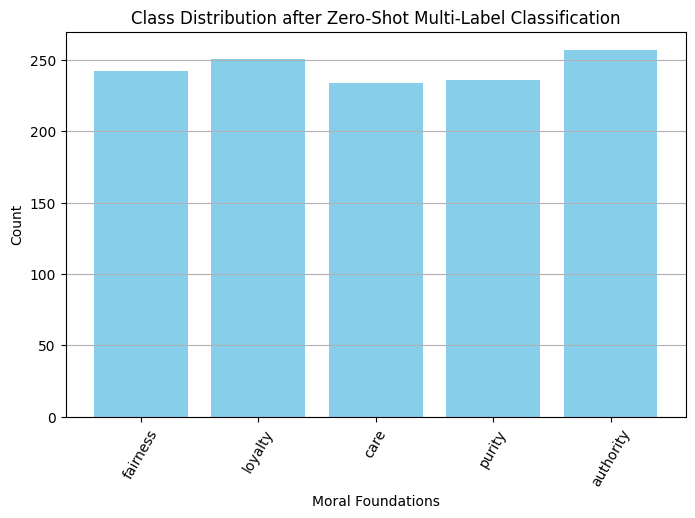

In [13]:
# Plot label counts vs threshold
plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title("Class Distribution after Zero-Shot Multi-Label Classification")
plt.xlabel("Moral Foundations")
plt.ylabel("Count")
plt.xticks(rotation=60)
plt.grid(axis='y')
plt.show()

In [13]:
# from transformers import pipeline

# # Load the zero-shot classification pipeline
# classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# text = "Helping the poor is a moral duty."
# candidate_labels = ["Care", "Fairness", "Loyalty", "Authority", "Sanctity", "Liberty"]

# # Perform zero-shot classification
# result = classifier(text, candidate_labels)
# print(result)


In [14]:
d

{'Why do they leave? High taxes, corruption, or simply better prospects elsewhere. The cure starts with systemic reform. #Brain Drain': ('Authority',),
 "At this rate, soon #EVM's will be on Amazon and Flipkart.": ('Fairness',),
 'Animal sacrifice laws must protect animals without targeting communities. #FairLaws': ('Fairness',),
 'how many "peak bengaluru" tweets are just gig workers struggling in a system which denies them basic labour rights?': ('Authority',),
 'Silent conversion is happening in every state of Bharat ! ji please bring #anticonversion law. We are losing generations .': ('Fairness',),
 'Justice delayed is justice denied for LGBTQ rights.': ('Fairness',),
 'True humanity lies in accepting differences, not condemning them.': ('Care',),
 'If gender equality matters, then the #UCC is the only way forward. Quit pretending otherwise.': ('Care',),
 'How can a law claim to be just if it excludes Muslims entirely?': ('Fairness',),
 'This law is a humanitarian step forward, and

## Few Shot learing
###     -Creating a data Farme of Zero shot labels and feeding them to compute few shot prediction

In [14]:
for item in d:
    d[item] = d[item][0].split(', ')

In [15]:
len(d)

1193

In [17]:
#data frame creation
few_shot_data = pd.DataFrame({
    "text": d.keys(),
    "labels":d.values()
})

In [18]:
few_shot_data.head()

,text,labels
0,are easy to manipulate this was demonstrated ...,[fairness]
1,congratulations\ncaa is arrived,[loyalty]
2,my dear indian muslims we are 35 crores of pop...,[loyalty]
3,this guy was part of anti hindu protests in th...,[fairness]
4,woman protester breaks down while speaking to ...,[care]


In [19]:
train_dataset, test_dataset = train_test_split(
    few_shot_data, test_size=0.2, random_state=42, shuffle=True
)

In [20]:
#creating encodings
mlb = MultiLabelBinarizer()
train_label = mlb.fit_transform(train_dataset['labels'])
test_label = mlb.fit_transform(test_dataset['labels'])

In [21]:
print(train_label)

[[0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 ...
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]


In [22]:
moral_foundations = list(mlb.classes_)
print(moral_foundations)

['authority', 'care', 'fairness', 'loyalty', 'purity']


In [23]:
#tokenizing the text
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_inputs = tokenizer(list(train_dataset["text"]), padding = True, truncation = True, return_tensors = "pt")
test_inputs = tokenizer(list(test_dataset["text"]), padding = True, truncation = True, return_tensors = "pt")

### Creating a data pipeline

In [24]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        for param in self.bert.parameters():
            param.requires_grad = False 
        for param in self.bert.encoder.layer[-7:].parameters():  # Unfreeze last 2 layers
            param.requires_grad = True


        self.dropout = nn.Dropout(0.2)  # Prevent overfitting
        # self.fc1 = nn.Linear(config.hidden_size, 512)
        # Fully connected classifier
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)  # Multi-label output

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, )
        pooled_output = outputs.pooler_output  # [CLS] token representation
        
        pooled_output = self.dropout(pooled_output)
        # pooled_output = self.fc1(pooled_output)
        logits = self.classifier(pooled_output)  # Output logits

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(label_smoothing=0.1)  # Multi-label classification loss
            loss = loss_fct(logits, labels)  # Ensure labels are float for BCE

        return {"loss": loss, "logits": logits}


In [25]:
num_labels = len(moral_foundations)  # Number of labels
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=num_labels)
model = BertForMultiLabelClassification.from_pretrained("bert-base-uncased", config=config)

Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model.to('cuda')

BertForMultiLabelClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

In [27]:
#labels to torch tensors
train_labels = torch.tensor(train_label, dtype = torch.float)
test_labels = torch.tensor(test_label, dtype = torch.float)

In [28]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    per_device_train_batch_size=4,  # Increased batch size
    per_device_eval_batch_size=4,
    num_train_epochs=5,  # Reduce to avoid overfitting
    warmup_steps=100,  # Stabilize training
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    fp16=True,  # Use mixed precision
    gradient_accumulation_steps=4,  # Effective batch size of 32
    learning_rate=2e-5,  # More stable LR
    #lr_scheduler_type="cosine",  # Better decay
    seed=42
)


In [29]:
#dataset
class TweetData(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        if len(labels.shape) > 1 and labels.shape[1] > 1:
            labels = labels.argmax(axis=1)  
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [30]:
#initializing the data set
train_dataset = TweetData(train_inputs, train_labels)
test_dataset = TweetData(test_inputs, test_labels)

In [31]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Convert logits to predicted class indices
    predictions = logits.argmax(axis=1)

    # Convert one-hot encoded labels to class indices (if needed)
    if len(labels.shape) > 1 and labels.shape[1] > 1:
        labels = labels.argmax(axis=1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [32]:
optimizer = AdamW([
    {"params": model.bert.encoder.layer[-7:].parameters(), "lr": 1e-5},  # Fine-tune last 6 layers
    # {"params": model.fc1.parameters(), "lr": 2e-3},  # Higher LR for classifier
    {"params": model.classifier.parameters(), "lr": 1e-3}
], weight_decay=0.01)


c:\Users\anura\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
num_training_steps = len(train_dataset) * training_args.num_train_epochs  # Total training steps
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [34]:
#setting the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  
    optimizers = (optimizer,lr_scheduler)
)

In [35]:
torch.cuda.empty_cache()


In [53]:
#training
trainer.train()

C:\Users\anura\AppData\Local\Temp\ipykernel_23600\3599150413.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.689900,1.764024,0.460251,0.458359,0.461777,0.460251
1,0.621000,1.822292,0.451883,0.448108,0.453186,0.451883
2,0.616400,1.885336,0.414226,0.396050,0.425412,0.414226
3,0.525400,1.840840,0.439331,0.430291,0.451988,0.439331
4,0.535400,1.816076,0.439331,0.434306,0.438876,0.439331


C:\Users\anura\AppData\Local\Temp\ipykernel_23600\3599150413.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
C:\Users\anura\AppData\Local\Temp\ipykernel_23600\3599150413.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
C:\Users\anura\AppData\Local\Temp\ipykernel_23600\3599150413.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
C:\U

TrainOutput(global_step=295, training_loss=0.5866898682157872, metrics={'train_runtime': 102.1954, 'train_samples_per_second': 46.675, 'train_steps_per_second': 2.887, 'total_flos': 271069243831584.0, 'train_loss': 0.5866898682157872, 'epoch': 4.98744769874477})

In [54]:
results = trainer.evaluate()
print("Evaluation results:", results)


C:\Users\anura\AppData\Local\Temp\ipykernel_23600\3599150413.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)


Evaluation results: {'eval_loss': 1.7640235424041748, 'eval_accuracy': 0.4602510460251046, 'eval_f1': 0.45835926254839277, 'eval_precision': 0.46177701917133457, 'eval_recall': 0.4602510460251046, 'eval_runtime': 1.7276, 'eval_samples_per_second': 138.34, 'eval_steps_per_second': 34.73, 'epoch': 4.98744769874477}


In [55]:
# Compute classification report
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

C:\Users\anura\AppData\Local\Temp\ipykernel_23600\3599150413.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)


In [56]:
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=mlb.classes_))

Classification Report:
               precision    recall  f1-score   support

   authority       0.47      0.55      0.50        49
        care       0.42      0.48      0.45        48
    fairness       0.43      0.35      0.39        46
     loyalty       0.51      0.43      0.47        46
      purity       0.48      0.48      0.48        50

    accuracy                           0.46       239
   macro avg       0.46      0.46      0.46       239
weighted avg       0.46      0.46      0.46       239



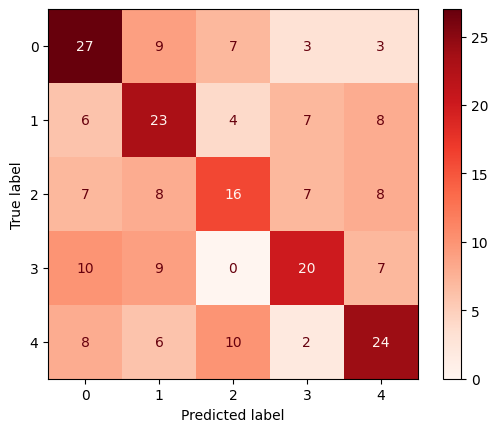

In [60]:
# Step 3: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Reds')
plt.show()

### predictions from the few shot model

In [40]:
#dropping the data used for zero shot prediction
remain_tweets = data.drop(few_shot_data.index)["Tweet Text"]

In [41]:
# Load tokenizer (ensure it matches the model)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [42]:
test_inputs = tokenizer(list(remain_tweets), padding=True, truncation=True, return_tensors="pt")

In [43]:
# Move input tensors to GPU
test_inputs = {k: v.to('cuda') for k, v in test_inputs.items()}

In [44]:
# Store predictions
all_predictions = []

In [45]:
batch_size = 32

In [46]:
# Predict in batches
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(0, len(remain_tweets), batch_size):
        batch_inputs = {k: v[i:i + batch_size] for k, v in test_inputs.items()}
        batch_outputs = model(**batch_inputs)  # Get outputss
        batch_logits = batch_outputs["logits"]
        batch_probs = torch.sigmoid(batch_logits)  # Convert to probabilities
        all_predictions.append(batch_probs)

In [54]:
# Concatenate all predictions
all_predictions = torch.cat(all_predictions, dim=0)

In [55]:
# Convert to numpy for easy manipulation
all_predictions = all_predictions.cpu().numpy()
# Apply threshold (0.5) to convert probabilities to binary labels
predicted_labels = (all_predictions > 0.6).astype(int)

In [56]:
print("Predictions Shape:", predicted_labels.shape)  # (num_samples, num_labels)

Predictions Shape: (116, 5)


In [57]:
print(predicted_labels)

[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]

# Testing with external dataset

In [1]:
external_data = pd.read_csv("External_testing.csv")

NameError: name 'pd' is not defined

In [43]:
len(external_data)

52

In [44]:
external_data.head()

,Corpus,Tweet Text,Foundations
0,CAA,The government must enforce stricter rules on ...,Authority
1,CAA,Respecting laws is a must! Illegal migration m...,"Authority,Fairness"
2,CAA,"CAA is about national security, not about disc...",Authority
3,CAA,The chaos around CAA protests proves why stric...,Authority
4,CAA,CAA provides a home to persecuted minorities. ...,"Care,Fairness"


In [45]:
from collections import Counter

d1 = dict()  # Dictionary to store tweet text and selected labels
all_predicted_labels = []  # List to collect all predicted labels

# Loop through each Tweet Text
for text in external_data["Tweet Text"]:
    # Assuming you have a classifier that returns a list of selected labels for each text
    # result = classifier(text, moral_foundations)  # Uncomment if you have a classifier

    # Simulating selected labels (replace this with actual logic)
    selected_labels = external_data.loc[external_data["Tweet Text"] == text, "Foundations"].tolist()

    # Store in dictionary
    d1[text] = tuple(selected_labels)
    # Collect all labels for counting
    all_predicted_labels.extend(selected_labels)

# Count occurrences of each label
label_counts = Counter(all_predicted_labels)

# Display results
print(d1)  # Dictionary with text → labels
print(label_counts)  # Count of each foundation label

{'The government must enforce stricter rules on CAA protests. A nation cannot function if people defy laws every time they disagree. #CAA #Authority': ('Authority',), 'Respecting laws is a must! Illegal migration must be checked, and CAA ensures that. #RuleOfLaw': ('Authority,Fairness',), 'CAA is about national security, not about discrimination. We must follow the rules and protect our nation. #NationalSecurity': ('Authority',), 'The chaos around CAA protests proves why stricter laws are needed. Public order must be maintained. #LawAndOrder': ('Authority',), 'CAA provides a home to persecuted minorities. Shouldn’t we care for those who suffered for their faith? #HumanityFirst': ('Care,Fairness',), 'Denying refuge to those fleeing persecution is against our values. Compassion must come before politics. #HelpTheNeedy': ('Care',), 'CAA ensures fairness by helping minorities from neighboring countries who have no other options. #Justice': ('Fairness',), 'Providing shelter to religious min

In [46]:
for item in d1:
    d1[item] = d1[item][0].split(',')

In [47]:
external_test_data = pd.DataFrame({
    "text": d1.keys(),
    "labels":d1.values()
})

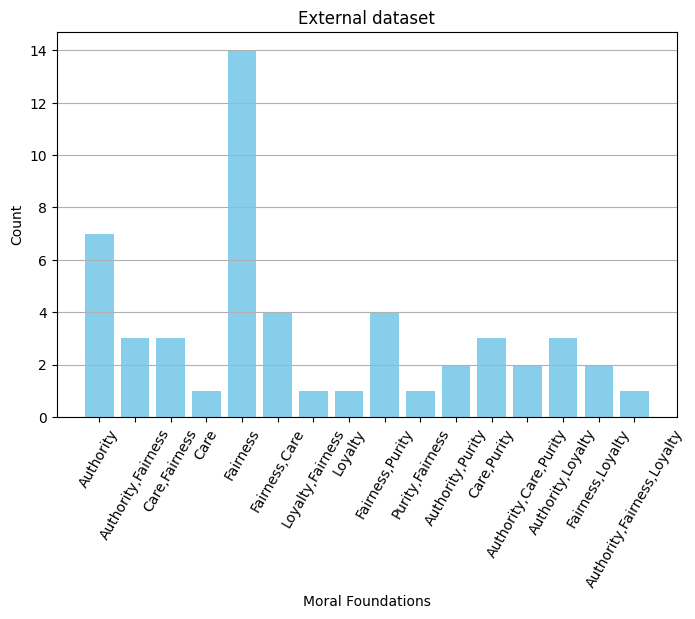

In [48]:
plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.title("External dataset")
plt.xlabel("Moral Foundations")
plt.ylabel("Count")
plt.xticks(rotation=60)
plt.grid(axis='y')
plt.show()

In [49]:
external_test_label = mlb.fit_transform(external_test_data['labels'])

In [50]:
print(external_test_label)

[[1 0 0 0 0]
 [1 0 1 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 1 0 0]
 [0 0 1 0 0]
 [0 0 1 1 0]
 [1 0 0 0 0]
 [1 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 1 0 1]
 [1 0 0 0 0]
 [0 1 1 0 0]
 [0 0 1 0 0]
 [1 0 1 0 0]
 [0 1 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 1]
 [0 0 1 0 1]
 [1 0 0 0 1]
 [0 1 1 0 0]
 [0 0 1 0 1]
 [0 0 1 0 0]
 [1 0 0 0 1]
 [0 1 0 0 1]
 [1 1 0 0 1]
 [0 1 0 0 1]
 [1 1 0 0 1]
 [0 1 0 0 1]
 [0 1 1 0 0]
 [0 0 1 0 1]
 [1 0 0 0 0]
 [1 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 1 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 1 0]
 [1 0 0 1 0]
 [1 0 1 1 0]
 [0 0 1 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 1 0 0]
 [0 0 1 0 0]]


In [51]:
external_test_inputs = tokenizer(list(external_test_data["text"]), padding = True, truncation = True, return_tensors = "pt")

In [52]:
external_test_label = torch.tensor(external_test_label, dtype = torch.float)

In [53]:
external_test_dataset = TweetData(external_test_inputs, external_test_label)

In [54]:
results = trainer.evaluate(external_test_dataset)
print("External Test Set Results:", results)

C:\Users\anura\AppData\Local\Temp\ipykernel_38352\814537897.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx], device="cpu") for key, val in self.encodings.items()}


External Test Set Results: {'eval_loss': 1.6050115823745728, 'eval_accuracy': 0.25, 'eval_f1': 0.41888090361592667, 'eval_precision': 0.5659159680898811, 'eval_recall': 0.35714285714285715, 'eval_runtime': 0.5594, 'eval_samples_per_second': 92.96, 'eval_steps_per_second': 23.24, 'epoch': 5.0}
